In [1]:
# import kagglehub

# # Download latest version
# path = kagglehub.model_download("google/yamnet/tensorFlow2/yamnet")

# print("Path to model files:", path)

In [2]:
import utils as u
import tensorflow_hub as hub

yamnet = hub.load('https://tfhub.dev/google/yamnet/1')

2024-04-30 11:30:08.107099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 11:30:13.821870: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# 指定你的音频文件夹路径
folder_path = 'DEAM_Dataset/MEMD_audio/'
# 处理文件夹并获取 embeddings
embeddings_dict = u.process_folder(folder_path, yamnet)

In [27]:
# 打印所有键
# print(list(embeddings_dict.keys()))
print(len(list(embeddings_dict.keys())))

5406


In [21]:
# 创建一个新字典，其键是转换后的格式
new_embeddings_dict = {}
for key in embeddings_dict.keys():
    if key[-3:] == 'aug':
        if key[-4] == '0':
            new_key = key[:-8] + ".1"   # for augmentation data, add ".1"
        if key[-4] == '3':
            new_key = key[:-8] + ".2"
    else:
        new_key = key[:-4] + ".0"  # 移除 '.mp3' 并添加 '.0'
        
    new_embeddings_dict[new_key] = embeddings_dict[key]




In [28]:
# 打印所有键
print(len(list(new_embeddings_dict.keys())))

5406


In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 加载 Arousal & Valence 数据
av_data = pd.read_csv('DEAM_Dataset/annotations/static_annotations_averaged_songs_1_2000.csv')  # 确保路径正确
print(av_data.head())

   song_id   valence_mean   valence_std   arousal_mean   arousal_std
0        2            3.1          0.94            3.0          0.63
1        3            3.5          1.75            3.3          1.62
2        4            5.7          1.42            5.5          1.63
3        5            4.4          2.01            5.3          1.85
4        7            5.8          1.47            6.4          1.69


In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 加载 Arousal & Valence 数据
av_data1 = pd.read_csv('DEAM_Dataset/annotations/static_annotations_averaged_songs_1_2000.csv')  # 确保路径正确
av_data2 = pd.read_csv('DEAM_Dataset/annotations/static_annotations_averaged_songs_2000_2058.csv')
av_data = pd.concat([av_data1, av_data2], ignore_index=True)
av_data.columns = av_data.columns.str.strip()  # 清理列名

# 初始化数据列表
X = []
y = []

# 遍历数据行
for index, row in av_data.iterrows():
    music_id = str(row['song_id'])  # 根据需要将 musicId 转换为字符串，假设 embeddings_dict 的键是字符串形式的 musicId
    if music_id in new_embeddings_dict:
        X.append(new_embeddings_dict[music_id])
        X.append(new_embeddings_dict[music_id[:-1] + "1"])
        X.append(new_embeddings_dict[music_id[:-1] + "2"])
        y.append([row['valence_mean'], row['arousal_mean']])
        y.append([row['valence_mean'], row['arousal_mean']])
        y.append([row['valence_mean'], row['arousal_mean']])
    else:
        print(f"Music ID {music_id} not found in embeddings_dict")  # 输出未找到的音乐 ID

# 将列表转换为 NumPy 数组
X = np.array(X)
y = np.array(y)

print(f"Total samples loaded: {len(X)}")  # 输出加载的样本总数

if len(X) > 0:
    # 划分数据集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")
else:
    print("No data to split. Check your dataset and embeddings.")


Total samples loaded: 5406
Training set size: 4324, Test set size: 1082


In [35]:
from models import build_model


from tensorflow.keras.models import Sequential
from tcn import TCN, tcn_full_summary
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


def build_model(input_shape):
    model = Sequential([
        TCN(input_shape=input_shape, nb_filters=64, kernel_size=6, nb_stacks=1,
            dilations=[1, 2, 4, 8, 16], padding='causal', use_skip_connections=True,
            dropout_rate=0.2, return_sequences=False, activation='relu', kernel_initializer='he_normal'),
        Dense(2, activation='linear', kernel_regularizer=l2(0.01))
    ])
    BatchNormalization(),
    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model
# 根据输入数据的形状创建模型
model = build_model(input_shape=(60, 1024))  # 确保这与你的 embeddings 形状匹配



In [36]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
136/136 [==============================] - 12s 78ms/step - loss: 16.9981 - mae: 1.6015 - val_loss: 1.0268 - val_mae: 0.7942
Epoch 2/20
136/136 [==============================] - 10s 74ms/step - loss: 1.0972 - mae: 0.8193 - val_loss: 1.0874 - val_mae: 0.8238
Epoch 3/20
136/136 [==============================] - 11s 82ms/step - loss: 0.9987 - mae: 0.7787 - val_loss: 0.8477 - val_mae: 0.7263
Epoch 4/20
136/136 [==============================] - 11s 81ms/step - loss: 0.9477 - mae: 0.7625 - val_loss: 0.8959 - val_mae: 0.7361
Epoch 5/20
136/136 [==============================] - 12s 87ms/step - loss: 0.9347 - mae: 0.7579 - val_loss: 0.7718 - val_mae: 0.6883
Epoch 6/20
136/136 [==============================] - 13s 96ms/step - loss: 0.8518 - mae: 0.7221 - val_loss: 0.8630 - val_mae: 0.7183
Epoch 7/20
136/136 [==============================] - 13s 96ms/step - loss: 0.8263 - mae: 0.7099 - val_loss: 0.8852 - val_mae: 0.7297
Epoch 8/20
136/136 [==============================] - 12s 89m

In [11]:
import matplotlib.pyplot as plt

def plot_loss(history):
    """
    Plot the training and validation loss and mae.

    Parameters
    ----------
    history : keras.callbacks.History
        The history object returned by the `fit` method of a Keras model.

    Returns
    -------
    None
    """
    mae = history.history["mae"]
    val_mae = history.history["val_mae"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(mae) + 1)
    plt.plot(epochs, mae, "bo", label="Training mae")
    plt.plot(epochs, val_mae, "b", label="Validation mae")
    plt.title("Training and validation mae")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

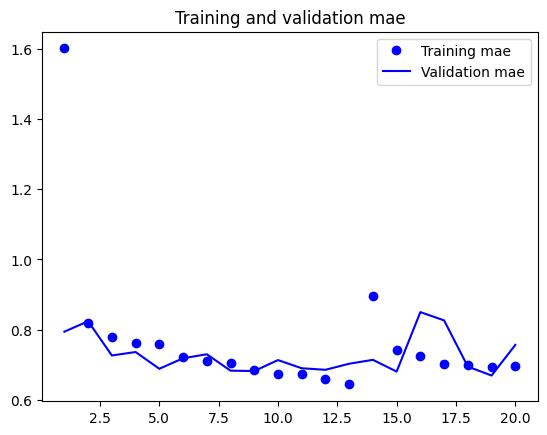

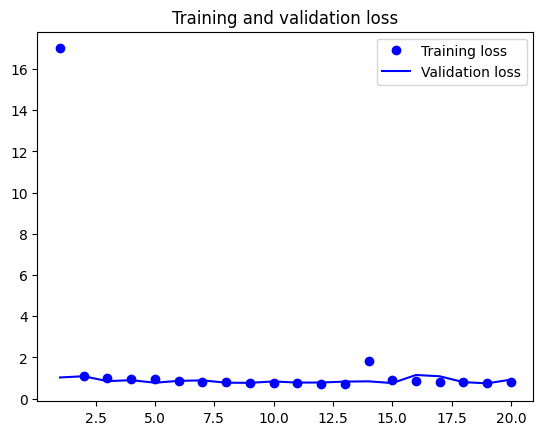

In [37]:
plot_loss(history)

In [38]:
# 评估模型性能
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test MAE: {mae}')


34/34 [==============================] - 1s 17ms/step - loss: 0.9222 - mae: 0.7563
Test Loss: 0.922179639339447, Test MAE: 0.7563273906707764


In [39]:
model.save('/Users/apple/Downloads/Group2_Final-Project-main/emotionPredict2.h5')  # 保存为 SavedModel 格式